In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random
import warnings

warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device set to: {device}")

✅ Device set to: cuda


In [2]:
# 1. Find File
file_path = None
base_dir = '/kaggle/input'
for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
        if 'cleaned_data' in filename:
            file_path = os.path.join(dirname, filename)
            break
            
if not file_path:
    raise FileNotFoundError("Could not find 'cleaned_data' in /kaggle/input")
    
print(f"Loading: {file_path}")

# 2. Load
if file_path.endswith('.csv'):
    df = pd.read_csv(file_path)
else:
    df = pd.read_excel(file_path)

# 3. Clean & Encode
if 'Lable' in df.columns:
    df.rename(columns={'Lable': 'Label'}, inplace=True)

label_map = {'Not Relevant': 0, 'Partially Relevant': 1, 'Highly Relevant': 2}
df['label'] = df['Label'].map(label_map)
class_names = ['Not Relevant', 'Partially Relevant', 'Highly Relevant']

# 4. Create Text Columns for Approaches
# Approach 1: Combined
df['text_combined'] = (
    "Genre: " + df['Symptoms Genre_cleaned'].astype(str) + 
    " Prompt: " + df['Used Prompt_cleaned'].astype(str) + 
    " Response: " + df['Response_cleaned'].astype(str)
)

# Approach 2: Response Only
df['text_response'] = "Response: " + df['Response_cleaned'].astype(str)

# 5. Split Data (80% Train, 10% Val, 10% Test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['label'])

print(f"Data Loaded. Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Loading: /kaggle/input/med-trust-clean/cleaned_data.xlsx
Data Loaded. Train: 12307, Val: 1538, Test: 1539


In [3]:
# 1. Tokenizer
def clean_and_tokenize(text):
    """Robust regex tokenizer for Bengali"""
    return re.findall(r'[\w\u0980-\u09FF]+', str(text).lower())

# 2. Build Vocabulary (from Training Data Approach 1 to cover all words)
print("Building Vocabulary...")
all_tokens = []
for text in train_df['text_combined']:
    all_tokens.extend(clean_and_tokenize(text))

from collections import Counter
counts = Counter(all_tokens)
# Top 15,000 words
vocab = sorted(counts, key=counts.get, reverse=True)[:15000]

word2idx = {w: i+2 for i, w in enumerate(vocab)}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1
print(f"✅ Vocabulary Size: {len(word2idx)}")

# 3. PyTorch Dataset
class BengaliDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_len=128):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        tokens = clean_and_tokenize(text)
        
        # Convert to IDs
        ids = [self.word2idx.get(t, 1) for t in tokens] # 1 is <UNK>
        
        # Pad/Truncate
        if len(ids) < self.max_len:
            ids = ids + [0] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
            
        return torch.tensor(ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)

Building Vocabulary...
✅ Vocabulary Size: 9906


In [5]:
class TextClassifierRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, output_dim=3, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # LSTM Layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, 
                            bidirectional=bidirectional, batch_first=True, dropout=0.3)
        
        # FC Layer input size depends on direction
        fc_in = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_in, output_dim)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, text):
        # text: [batch, seq_len]
        embedded = self.dropout(self.embedding(text))
        
        # lstm_out: [batch, seq_len, hidden_dim * dirs]
        lstm_out, _ = self.lstm(embedded)
        
        # Global Max Pooling (Taking the max value across the sequence dimension)
        # This handles padding much better than taking the last hidden state
        pooled = torch.max(lstm_out, dim=1)[0]
        
        return self.fc(pooled)

In [9]:
def plot_history(history, title):
    epochs = [h['epoch'] for h in history]
    loss = [h['loss'] for h in history]
    val_loss = [h['val_loss'] for h in history] # Now this will work
    train_acc = [h['train_acc'] for h in history]
    val_acc = [h['val_acc'] for h in history]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss Plot
    ax[0].plot(epochs, loss, label='Train Loss', marker='.')
    ax[0].plot(epochs, val_loss, label='Val Loss', marker='.')
    ax[0].set_title(f'{title} - Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)
    
    # Accuracy Plot
    ax[1].plot(epochs, train_acc, label='Train Acc', marker='.')
    ax[1].plot(epochs, val_acc, label='Val Acc', marker='.')
    ax[1].set_title(f'{title} - Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True)
    
    plt.show()

def plot_multiclass_roc(y_test, y_probs, n_classes, title):
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    plt.figure(figsize=(8, 6))
    colors = ['red', 'blue', 'green']
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, 
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{title} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def run_experiment(model_name, col_name, bidirectional=True):
    print(f"\n{'='*40}")
    print(f"🚀 Running: {model_name}")
    print(f"{'='*40}")
    
    # 1. Prepare Loaders
    train_ds = BengaliDataset(train_df[col_name].tolist(), train_df['label'].tolist(), word2idx)
    val_ds = BengaliDataset(val_df[col_name].tolist(), val_df['label'].tolist(), word2idx)
    test_ds = BengaliDataset(test_df[col_name].tolist(), test_df['label'].tolist(), word2idx)
    
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)
    test_loader = DataLoader(test_ds, batch_size=32)
    
    # 2. Init Model
    model = TextClassifierRNN(len(word2idx), bidirectional=bidirectional).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # 3. Train Loop
    history = []
    epochs = 15
    
    for epoch in range(epochs):
        # --- TRAIN ---
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for text, labels in train_loader:
            text, labels = text.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(text)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)
            
        train_acc = correct / total
        avg_train_loss = total_loss / len(train_loader)
        
        # --- VALIDATE ---
        model.eval()
        v_correct, v_total = 0, 0
        v_loss_sum = 0 # <--- FIX: Initialize loss sum
        
        with torch.no_grad():
            for text, labels in val_loader:
                text, labels = text.to(device), labels.to(device)
                preds = model(text)
                
                # Calculate Loss
                loss = criterion(preds, labels) # <--- FIX: Compute loss
                v_loss_sum += loss.item()       # <--- FIX: Accumulate loss
                
                v_correct += (preds.argmax(1) == labels).sum().item()
                v_total += labels.size(0)
        
        val_acc = v_correct / v_total
        avg_val_loss = v_loss_sum / len(val_loader) # <--- FIX: Average loss
        
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        
        # Store in history
        history.append({
            'epoch': epoch+1, 
            'loss': avg_train_loss, 
            'val_loss': avg_val_loss, # <--- FIX: Store it
            'train_acc': train_acc, 
            'val_acc': val_acc
        })
        
    # 4. Evaluation & Plots
    plot_history(history, model_name)
    
    print("Evaluating on Test Set...")
    model.eval()
    all_preds, all_true, all_probs = [], [], []
    with torch.no_grad():
        for text, labels in test_loader:
            text = text.to(device)
            preds = model(text)
            probs = torch.nn.functional.softmax(preds, dim=1)
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_true.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
            
    # Classification Report
    print(f"\n--- Classification Report: {model_name} ---")
    print(classification_report(all_true, all_preds, target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # ROC
    plot_multiclass_roc(np.array(all_true), np.array(all_probs), 3, model_name)


🚀 Running: BiLSTM_Approach_1_Combined
Epoch 1/15 | Loss: 0.9041 | Val Loss: 0.7818 | Train Acc: 0.5579 | Val Acc: 0.6515
Epoch 2/15 | Loss: 0.6940 | Val Loss: 0.6989 | Train Acc: 0.6926 | Val Acc: 0.7107
Epoch 3/15 | Loss: 0.5841 | Val Loss: 0.6215 | Train Acc: 0.7454 | Val Acc: 0.7523
Epoch 4/15 | Loss: 0.4994 | Val Loss: 0.6065 | Train Acc: 0.7909 | Val Acc: 0.7692
Epoch 5/15 | Loss: 0.4185 | Val Loss: 0.7226 | Train Acc: 0.8294 | Val Acc: 0.7172
Epoch 6/15 | Loss: 0.3644 | Val Loss: 0.5937 | Train Acc: 0.8524 | Val Acc: 0.7776
Epoch 7/15 | Loss: 0.3072 | Val Loss: 0.6417 | Train Acc: 0.8763 | Val Acc: 0.7659
Epoch 8/15 | Loss: 0.2597 | Val Loss: 0.6064 | Train Acc: 0.8996 | Val Acc: 0.7867
Epoch 9/15 | Loss: 0.2233 | Val Loss: 0.7219 | Train Acc: 0.9134 | Val Acc: 0.7802
Epoch 10/15 | Loss: 0.1913 | Val Loss: 0.6252 | Train Acc: 0.9262 | Val Acc: 0.8030
Epoch 11/15 | Loss: 0.1652 | Val Loss: 0.7098 | Train Acc: 0.9401 | Val Acc: 0.7848
Epoch 12/15 | Loss: 0.1497 | Val Loss: 0.6411 

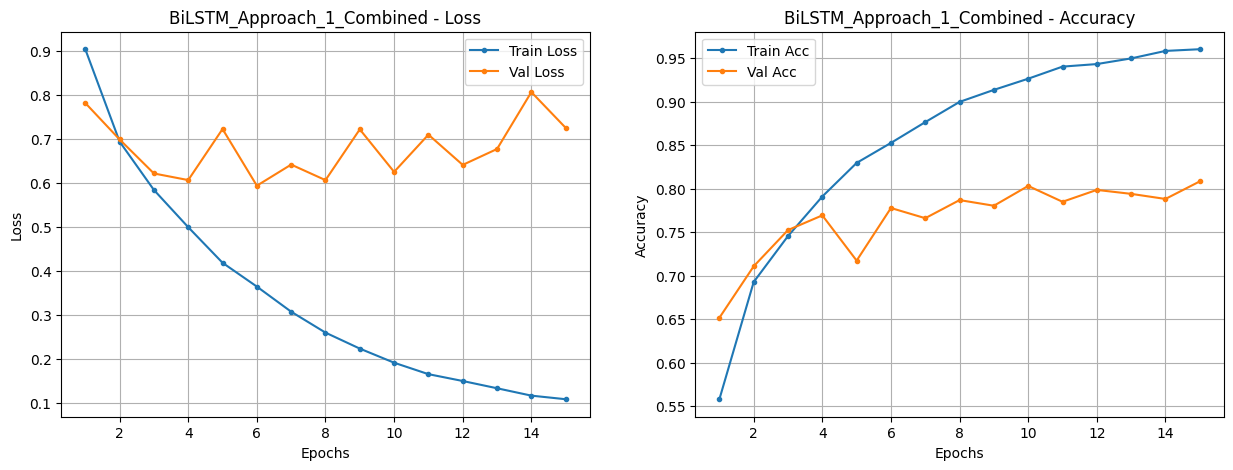

Evaluating on Test Set...

--- Classification Report: BiLSTM_Approach_1_Combined ---
                    precision    recall  f1-score   support

      Not Relevant     0.8684    0.8701    0.8692       508
Partially Relevant     0.7221    0.7943    0.7565       530
   Highly Relevant     0.8635    0.7705    0.8143       501

          accuracy                         0.8116      1539
         macro avg     0.8180    0.8116    0.8134      1539
      weighted avg     0.8164    0.8116    0.8125      1539



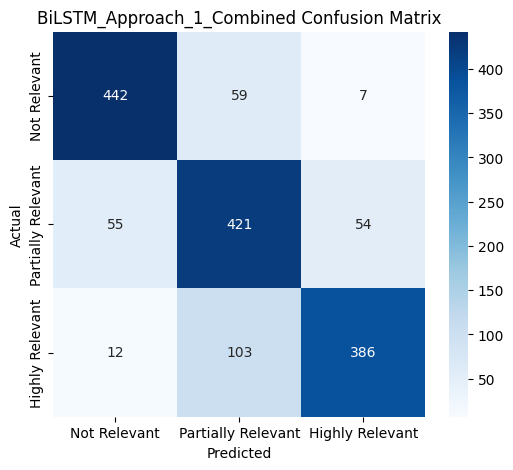

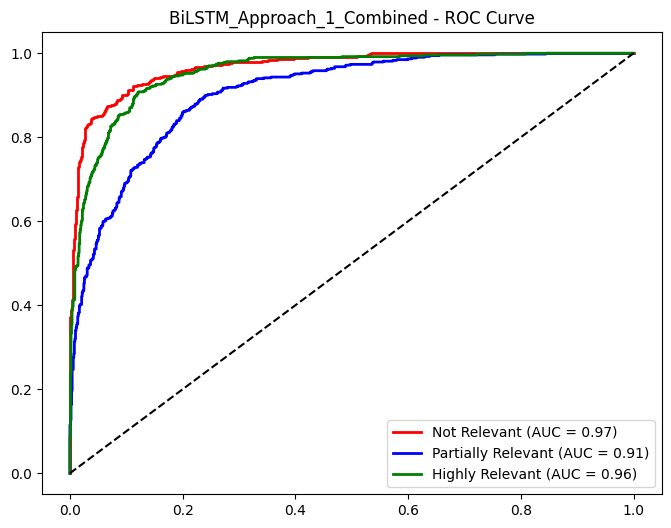


🚀 Running: LSTM_Approach_1_Combined
Epoch 1/15 | Loss: 0.9452 | Val Loss: 0.8181 | Train Acc: 0.5285 | Val Acc: 0.6417
Epoch 2/15 | Loss: 0.7532 | Val Loss: 0.7392 | Train Acc: 0.6673 | Val Acc: 0.6866
Epoch 3/15 | Loss: 0.6878 | Val Loss: 0.6724 | Train Acc: 0.7018 | Val Acc: 0.7230
Epoch 4/15 | Loss: 0.5908 | Val Loss: 0.7151 | Train Acc: 0.7488 | Val Acc: 0.7100
Epoch 5/15 | Loss: 0.5302 | Val Loss: 0.7253 | Train Acc: 0.7785 | Val Acc: 0.7230
Epoch 6/15 | Loss: 0.4717 | Val Loss: 0.7127 | Train Acc: 0.8050 | Val Acc: 0.7165
Epoch 7/15 | Loss: 0.4271 | Val Loss: 0.5877 | Train Acc: 0.8259 | Val Acc: 0.7763
Epoch 8/15 | Loss: 0.3845 | Val Loss: 0.5456 | Train Acc: 0.8483 | Val Acc: 0.7841
Epoch 9/15 | Loss: 0.3505 | Val Loss: 0.5773 | Train Acc: 0.8593 | Val Acc: 0.7757
Epoch 10/15 | Loss: 0.3149 | Val Loss: 0.7251 | Train Acc: 0.8767 | Val Acc: 0.7328
Epoch 11/15 | Loss: 0.2900 | Val Loss: 0.6284 | Train Acc: 0.8874 | Val Acc: 0.7724
Epoch 12/15 | Loss: 0.2653 | Val Loss: 0.6383 | 

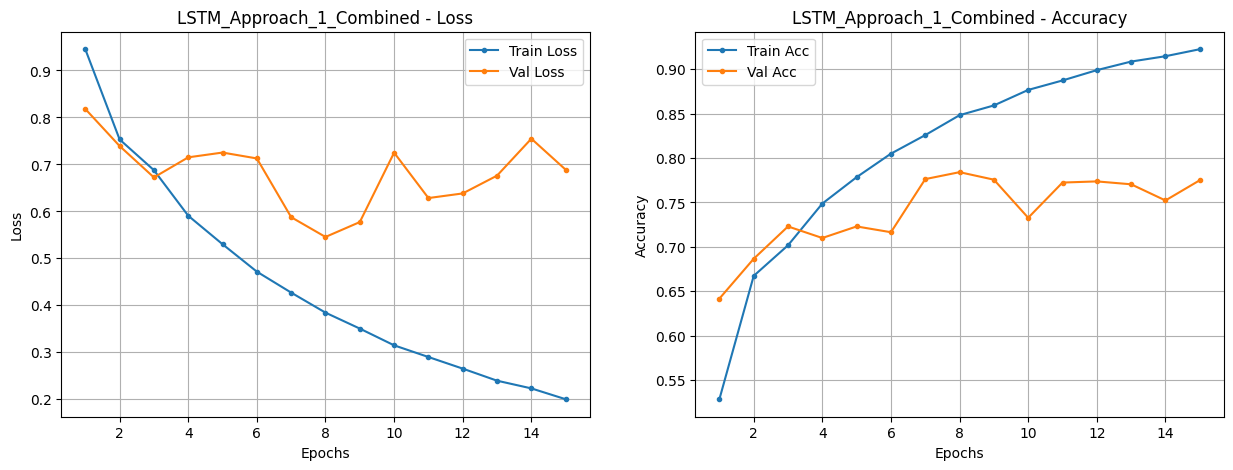

Evaluating on Test Set...

--- Classification Report: LSTM_Approach_1_Combined ---
                    precision    recall  f1-score   support

      Not Relevant     0.7704    0.9114    0.8350       508
Partially Relevant     0.6689    0.7585    0.7109       530
   Highly Relevant     0.9169    0.6168    0.7375       501

          accuracy                         0.7628      1539
         macro avg     0.7854    0.7622    0.7611      1539
      weighted avg     0.7831    0.7628    0.7605      1539



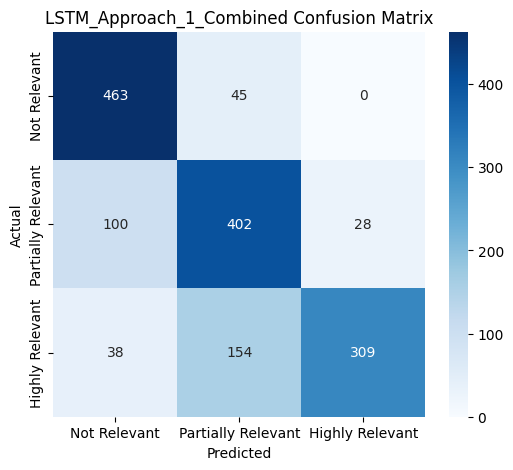

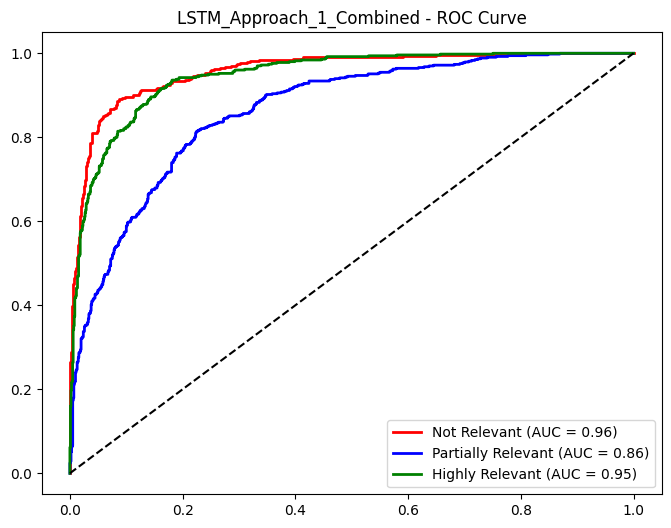

In [10]:
# BiLSTM
run_experiment("BiLSTM_Approach_1_Combined", "text_combined", bidirectional=True)

# LSTM
run_experiment("LSTM_Approach_1_Combined", "text_combined", bidirectional=False)


🚀 Running: BiLSTM_Approach_2_Response_Only
Epoch 1/15 | Loss: 0.8646 | Val Loss: 0.7366 | Train Acc: 0.5843 | Val Acc: 0.6775
Epoch 2/15 | Loss: 0.6833 | Val Loss: 0.7032 | Train Acc: 0.6976 | Val Acc: 0.7074
Epoch 3/15 | Loss: 0.5852 | Val Loss: 0.6684 | Train Acc: 0.7474 | Val Acc: 0.7334
Epoch 4/15 | Loss: 0.5064 | Val Loss: 0.6570 | Train Acc: 0.7877 | Val Acc: 0.7289
Epoch 5/15 | Loss: 0.4293 | Val Loss: 0.6963 | Train Acc: 0.8255 | Val Acc: 0.7308
Epoch 6/15 | Loss: 0.3637 | Val Loss: 0.6107 | Train Acc: 0.8544 | Val Acc: 0.7763
Epoch 7/15 | Loss: 0.3117 | Val Loss: 0.6097 | Train Acc: 0.8751 | Val Acc: 0.7757
Epoch 8/15 | Loss: 0.2719 | Val Loss: 0.5980 | Train Acc: 0.8928 | Val Acc: 0.7939
Epoch 9/15 | Loss: 0.2232 | Val Loss: 0.7118 | Train Acc: 0.9164 | Val Acc: 0.7705
Epoch 10/15 | Loss: 0.1913 | Val Loss: 0.7306 | Train Acc: 0.9278 | Val Acc: 0.7679
Epoch 11/15 | Loss: 0.1731 | Val Loss: 0.7719 | Train Acc: 0.9344 | Val Acc: 0.7750
Epoch 12/15 | Loss: 0.1468 | Val Loss: 0.

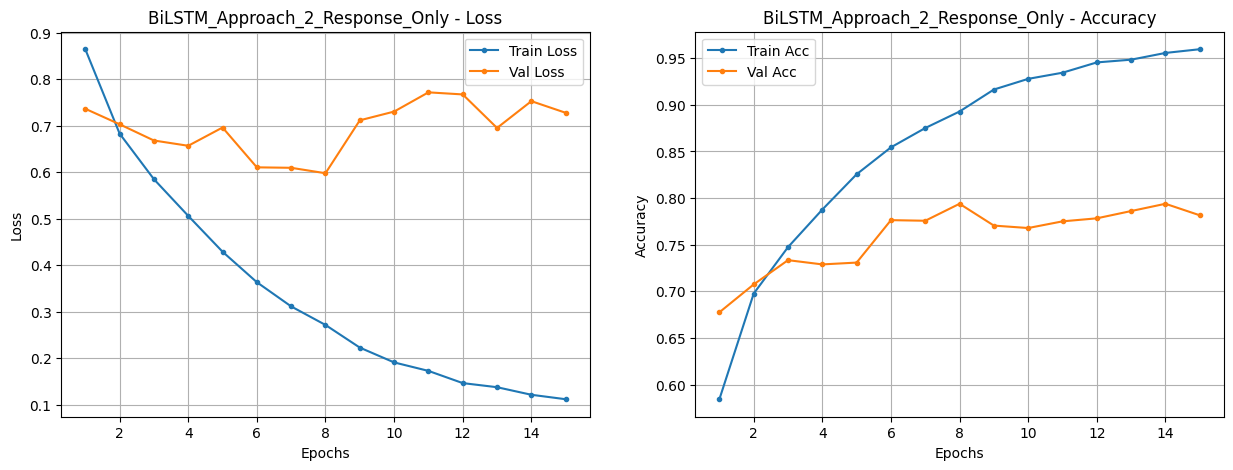

Evaluating on Test Set...

--- Classification Report: BiLSTM_Approach_2_Response_Only ---
                    precision    recall  f1-score   support

      Not Relevant     0.8131    0.8563    0.8341       508
Partially Relevant     0.6934    0.7509    0.7210       530
   Highly Relevant     0.8535    0.7325    0.7884       501

          accuracy                         0.7797      1539
         macro avg     0.7867    0.7799    0.7812      1539
      weighted avg     0.7850    0.7797    0.7803      1539



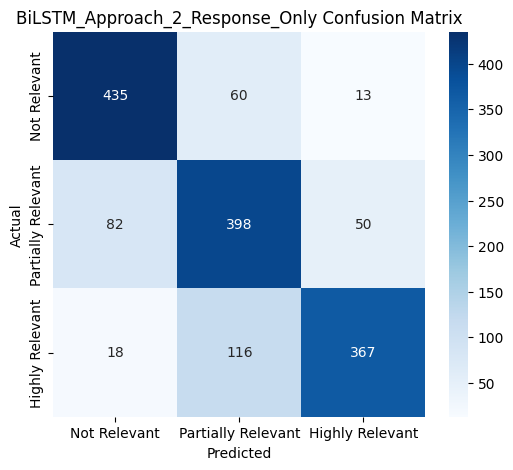

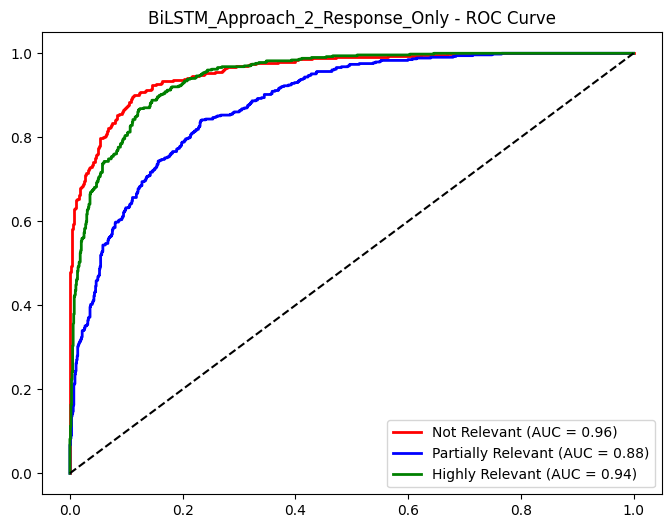


🚀 Running: LSTM_Approach_2_Response_Only
Epoch 1/15 | Loss: 0.9069 | Val Loss: 0.7864 | Train Acc: 0.5538 | Val Acc: 0.6502
Epoch 2/15 | Loss: 0.7235 | Val Loss: 0.7107 | Train Acc: 0.6810 | Val Acc: 0.7022
Epoch 3/15 | Loss: 0.6333 | Val Loss: 0.6734 | Train Acc: 0.7255 | Val Acc: 0.7302
Epoch 4/15 | Loss: 0.5610 | Val Loss: 0.7814 | Train Acc: 0.7601 | Val Acc: 0.6827
Epoch 5/15 | Loss: 0.4996 | Val Loss: 0.7402 | Train Acc: 0.7894 | Val Acc: 0.7087
Epoch 6/15 | Loss: 0.4429 | Val Loss: 0.6756 | Train Acc: 0.8178 | Val Acc: 0.7406
Epoch 7/15 | Loss: 0.3977 | Val Loss: 0.5861 | Train Acc: 0.8374 | Val Acc: 0.7672
Epoch 8/15 | Loss: 0.3496 | Val Loss: 0.6975 | Train Acc: 0.8582 | Val Acc: 0.7334
Epoch 9/15 | Loss: 0.3182 | Val Loss: 0.8200 | Train Acc: 0.8747 | Val Acc: 0.7243
Epoch 10/15 | Loss: 0.2793 | Val Loss: 0.7657 | Train Acc: 0.8890 | Val Acc: 0.7438
Epoch 11/15 | Loss: 0.2534 | Val Loss: 0.7367 | Train Acc: 0.9009 | Val Acc: 0.7523
Epoch 12/15 | Loss: 0.2275 | Val Loss: 0.73

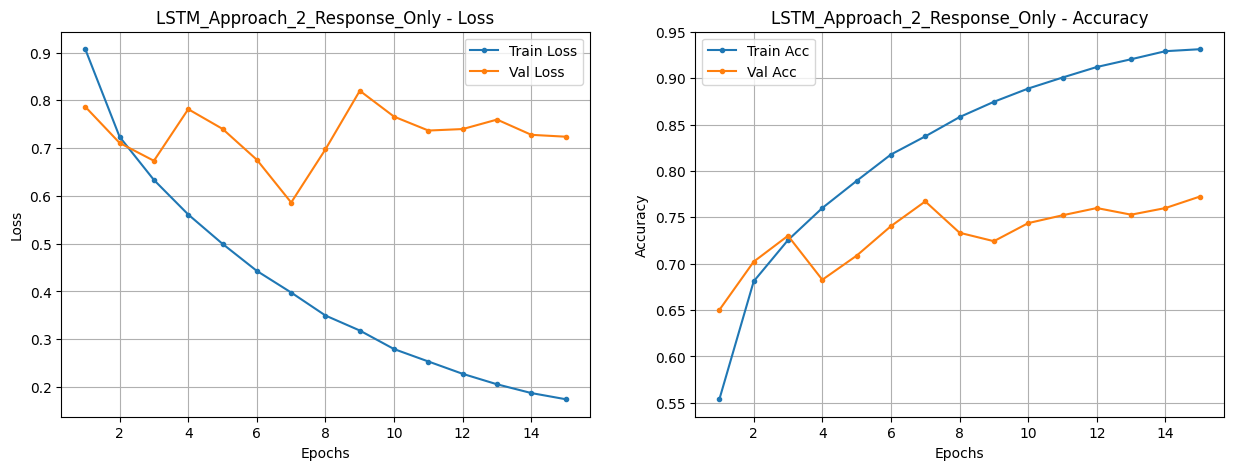

Evaluating on Test Set...

--- Classification Report: LSTM_Approach_2_Response_Only ---
                    precision    recall  f1-score   support

      Not Relevant     0.7920    0.8543    0.8220       508
Partially Relevant     0.7024    0.7660    0.7329       530
   Highly Relevant     0.8499    0.7006    0.7681       501

          accuracy                         0.7739      1539
         macro avg     0.7814    0.7737    0.7743      1539
      weighted avg     0.7800    0.7739    0.7737      1539



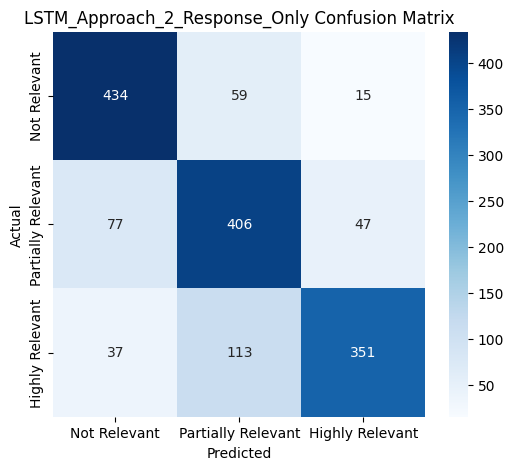

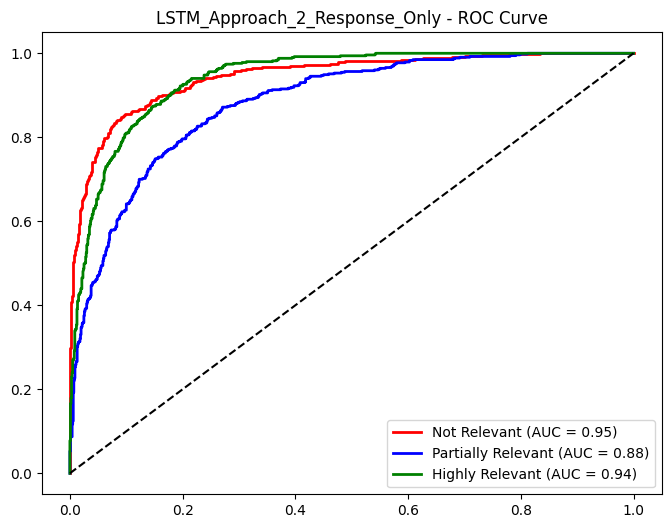

In [11]:
# BiLSTM
run_experiment("BiLSTM_Approach_2_Response_Only", "text_response", bidirectional=True)

# LSTM
run_experiment("LSTM_Approach_2_Response_Only", "text_response", bidirectional=False)